# Introduction

# Setup

## Helper Functions

In [1]:
def visualize(model, X, y, h=0.01):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    #performing predictions on grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # plotting the results
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # plotting training points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

## Imports

In [2]:
import math
import pprint
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.datasets import load_boston, load_diabetes
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.datasets import make_blobs

## Loading Dataset & Preprocessing

In [117]:
iris = load_iris()
breast = load_breast_cancer()
dataset = breast

X = dataset.data
y = dataset.target

xTrain, xTest, yTrain, yTest = train_test_split(X,y)

# Classification using KNN

In [3]:
class CustomKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5, plot=False):
        self.k = k
        self.plot = plot
        
    
    def fit(self, X, y):
        self._check_params(X,y)
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.fitted_ = True
        return self
    
    
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 2
            y_preds = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                counts = self._get_counts(neighbors)
                
                y_pred = max(counts.items(), key=operator.itemgetter(1))[0]
                y_preds.append(y_pred)
                
            return y_preds
        
    
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [(np.sqrt(np.sum(((X[i] - x) ** 2))))  for i in range(self.n)]
        
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

                
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
    
    
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')

### CustomKNeighborsClassifier vs KNeighborsClassifier

In [120]:
skModel = KNeighborsClassifier().fit(xTrain, yTrain)
custModel = CustomKNeighborsClassifier().fit(xTrain, yTrain)

print(cross_val_score(estimator=skModel, X=xTest, y=yTest, cv=5))
print(cross_val_score(estimator=custModel, X=xTest, y=yTest, cv=5))

[ 0.89655172  0.96551724  0.89655172  1.          0.96296296]
[ 0.89655172  0.96551724  0.89655172  1.          0.96296296]


## Visualizing KNN Decision Boundary

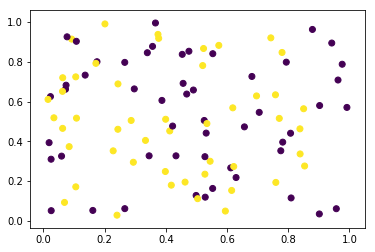

In [11]:
X = np.random.rand(100,2)
y = np.random.randint(0,2, 100)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

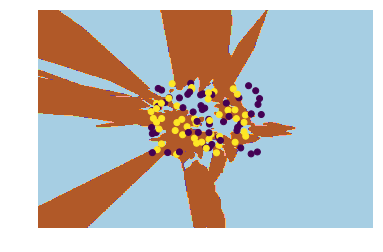

In [12]:
visualize(X=X, y=y, model=KNeighborsClassifier().fit(X,y))

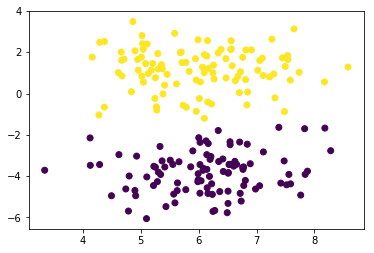

In [9]:
X,y = make_blobs(n_features=2, cluster_std=1, centers=2, n_samples=200)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

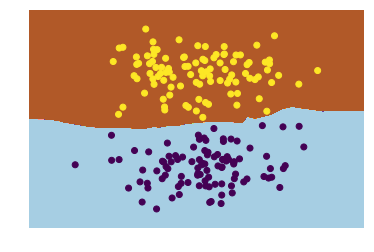

In [10]:
visualize(X=X, y=y, model=KNeighborsClassifier().fit(X,y))

## Vornoi Tesselation

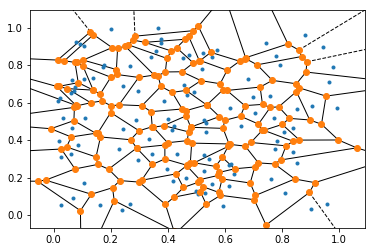

In [14]:
from scipy.spatial import Voronoi, voronoi_plot_2d
voronoi = Voronoi(X)
voronoi_plot_2d(voronoi)
plt.show()

## Weighted KNN

In [3]:
class WeightedKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5, plot=False):
        self.k = k
        self.plot = plot
        
    
    def fit(self, X, y):
        self._check_params(X,y)
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.fitted_ = True
        return self
    
    
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 2
            y_preds = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                counts = self._get_counts(neighbors)
                
                y_pred = max(counts.items(), key=operator.itemgetter(1))[0]
                y_preds.append(y_pred)
                
            return y_preds
        
    
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [(np.sqrt(np.sum((1/np.linalg.norm(X[i]-x)) * ((X[i] - x) ** 2))))  for i in range(self.n)]
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

                
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
    
    
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')

In [122]:
custModel = CustomKNeighborsClassifier().fit(xTrain, yTrain)
weightedKNN = WeightedKNeighborsClassifier().fit(xTrain, yTrain)

print(cross_val_score(estimator=custModel, X=xTest, y=yTest, cv=5))
print(cross_val_score(estimator=weightedKNN, X=xTest, y=yTest, cv=5))

[ 0.89655172  0.96551724  0.89655172  1.          0.96296296]
[ 0.89655172  0.96551724  0.89655172  1.          0.96296296]


# Regression using KNN

In [4]:
class CustomKNeighborsRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, k=5, plot=False):
        self.k = k
        self.plot = plot
        
    
    def fit(self, X, y):
        self._check_params(X,y)
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.fitted_ = True
        return self
    
    
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 2
            y_preds = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                counts = self._get_counts(neighbors)
                
                y_pred = np.mean(list(counts.keys()))
                y_preds.append(y_pred)
                
            return y_preds
        
    
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [(np.sqrt(np.sum(((X[i] - x) ** 2))))  for i in range(self.n)]
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

                
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
    
    
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')

In [128]:
boston = load_boston()
diabetes = load_diabetes()
dataset = diabetes

X = dataset.data
y = dataset.target

xTrain, xTest, yTrain, yTest = train_test_split(X,y)

### CustomKNeighborsRegressor vs KNeighborsRegressor

In [130]:
skModel = KNeighborsRegressor().fit(xTrain, yTrain)
custModel = CustomKNeighborsRegressor().fit(xTrain, yTrain)

print(cross_val_score(estimator=skModel, X=xTest, y=yTest, cv=5))
print(cross_val_score(estimator=custModel, X=xTest, y=yTest, cv=5))

[ 0.44948826  0.14413989  0.16012101  0.33023384  0.37881632]
[ 0.44948826  0.14413989  0.16861684  0.33207575  0.37881632]


## Regression using Weighted KNN

In [5]:
class WeightedKNeighborsRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, k=5, plot=False):
        self.k = k
        self.plot = plot
        
    
    def fit(self, X, y):
        self._check_params(X,y)
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.fitted_ = True
        return self
    
    
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 2
            y_preds = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                counts = self._get_counts(neighbors)
                
                y_pred = np.mean(list(counts.keys()))
                y_preds.append(y_pred)
                
            return y_preds
        
    
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [(np.sqrt(np.sum((1/np.linalg.norm(X[i]-x)) * ((X[i] - x) ** 2))))  for i in range(self.n)]
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

                
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
    
    
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')

In [134]:
custModel = CustomKNeighborsRegressor().fit(xTrain, yTrain)
weightedKNN = WeightedKNeighborsRegressor().fit(xTrain, yTrain)

print(cross_val_score(estimator=custModel, X=xTest, y=yTest, cv=5))
print(cross_val_score(estimator=weightedKNN, X=xTest, y=yTest, cv=5))

[ 0.44948826  0.14413989  0.16861684  0.33207575  0.37881632]
[ 0.44948826  0.14413989  0.16861684  0.33207575  0.37881632]
